In [102]:
import pandas as pd
import numpy as np

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)

# 1.Inspect the raw data

## 1.1 Check correlation

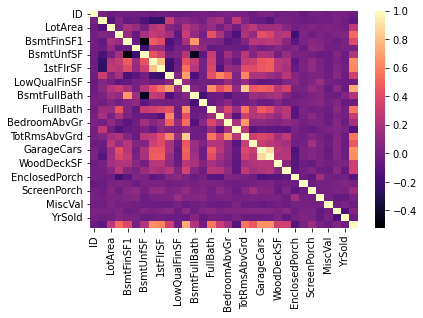

In [103]:
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

# Check correlation - but what do I do if correlation is high?
sb.heatmap(train_data.corr(), cmap = 'magma')
plt.savefig('heatmap.png', format='png')
plt.show()

## 1.2 Check data types

In [104]:
# Check data types for categoricals
categoricals_train = set(train_data.dtypes[train_data.dtypes=='object'].index)
categoricals_test = set(train_data.dtypes[train_data.dtypes=='object'].index)

print(categoricals_train-categoricals_test) # Check if categorical sets different. 0 = no diffs.
print(categoricals_train) # Manual inspection tells me that OverallQual, YearBuilt, OverallCond need to change their dtypes from strings/objects to numerical


set()
{'HouseStyle', 'OverallQual', 'YearBuilt', 'OverallCond', 'Street', 'ExterQual', 'BldgType', 'LotConfig'}


## 1.3 Inspect outliers

In [105]:
import matplotlib.pyplot as plt
import math

def plot_custom_subplot(df_obj, y_series, num_cols=int(5), plot_type='scatter'):

    num_plots = len(df_obj.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df_obj.columns[k])
            if plot_type == 'scatter':
                axes.scatter(df_obj.iloc[:, k], y_series)
            elif plot_type == 'histogram':
                axes.hist(df_obj.iloc[:, k])
            k += 1
            if k == num_plots:
                break
    
    plt.show()    
    plt.savefig('train_data_' + plot_type + '.png', format='png')

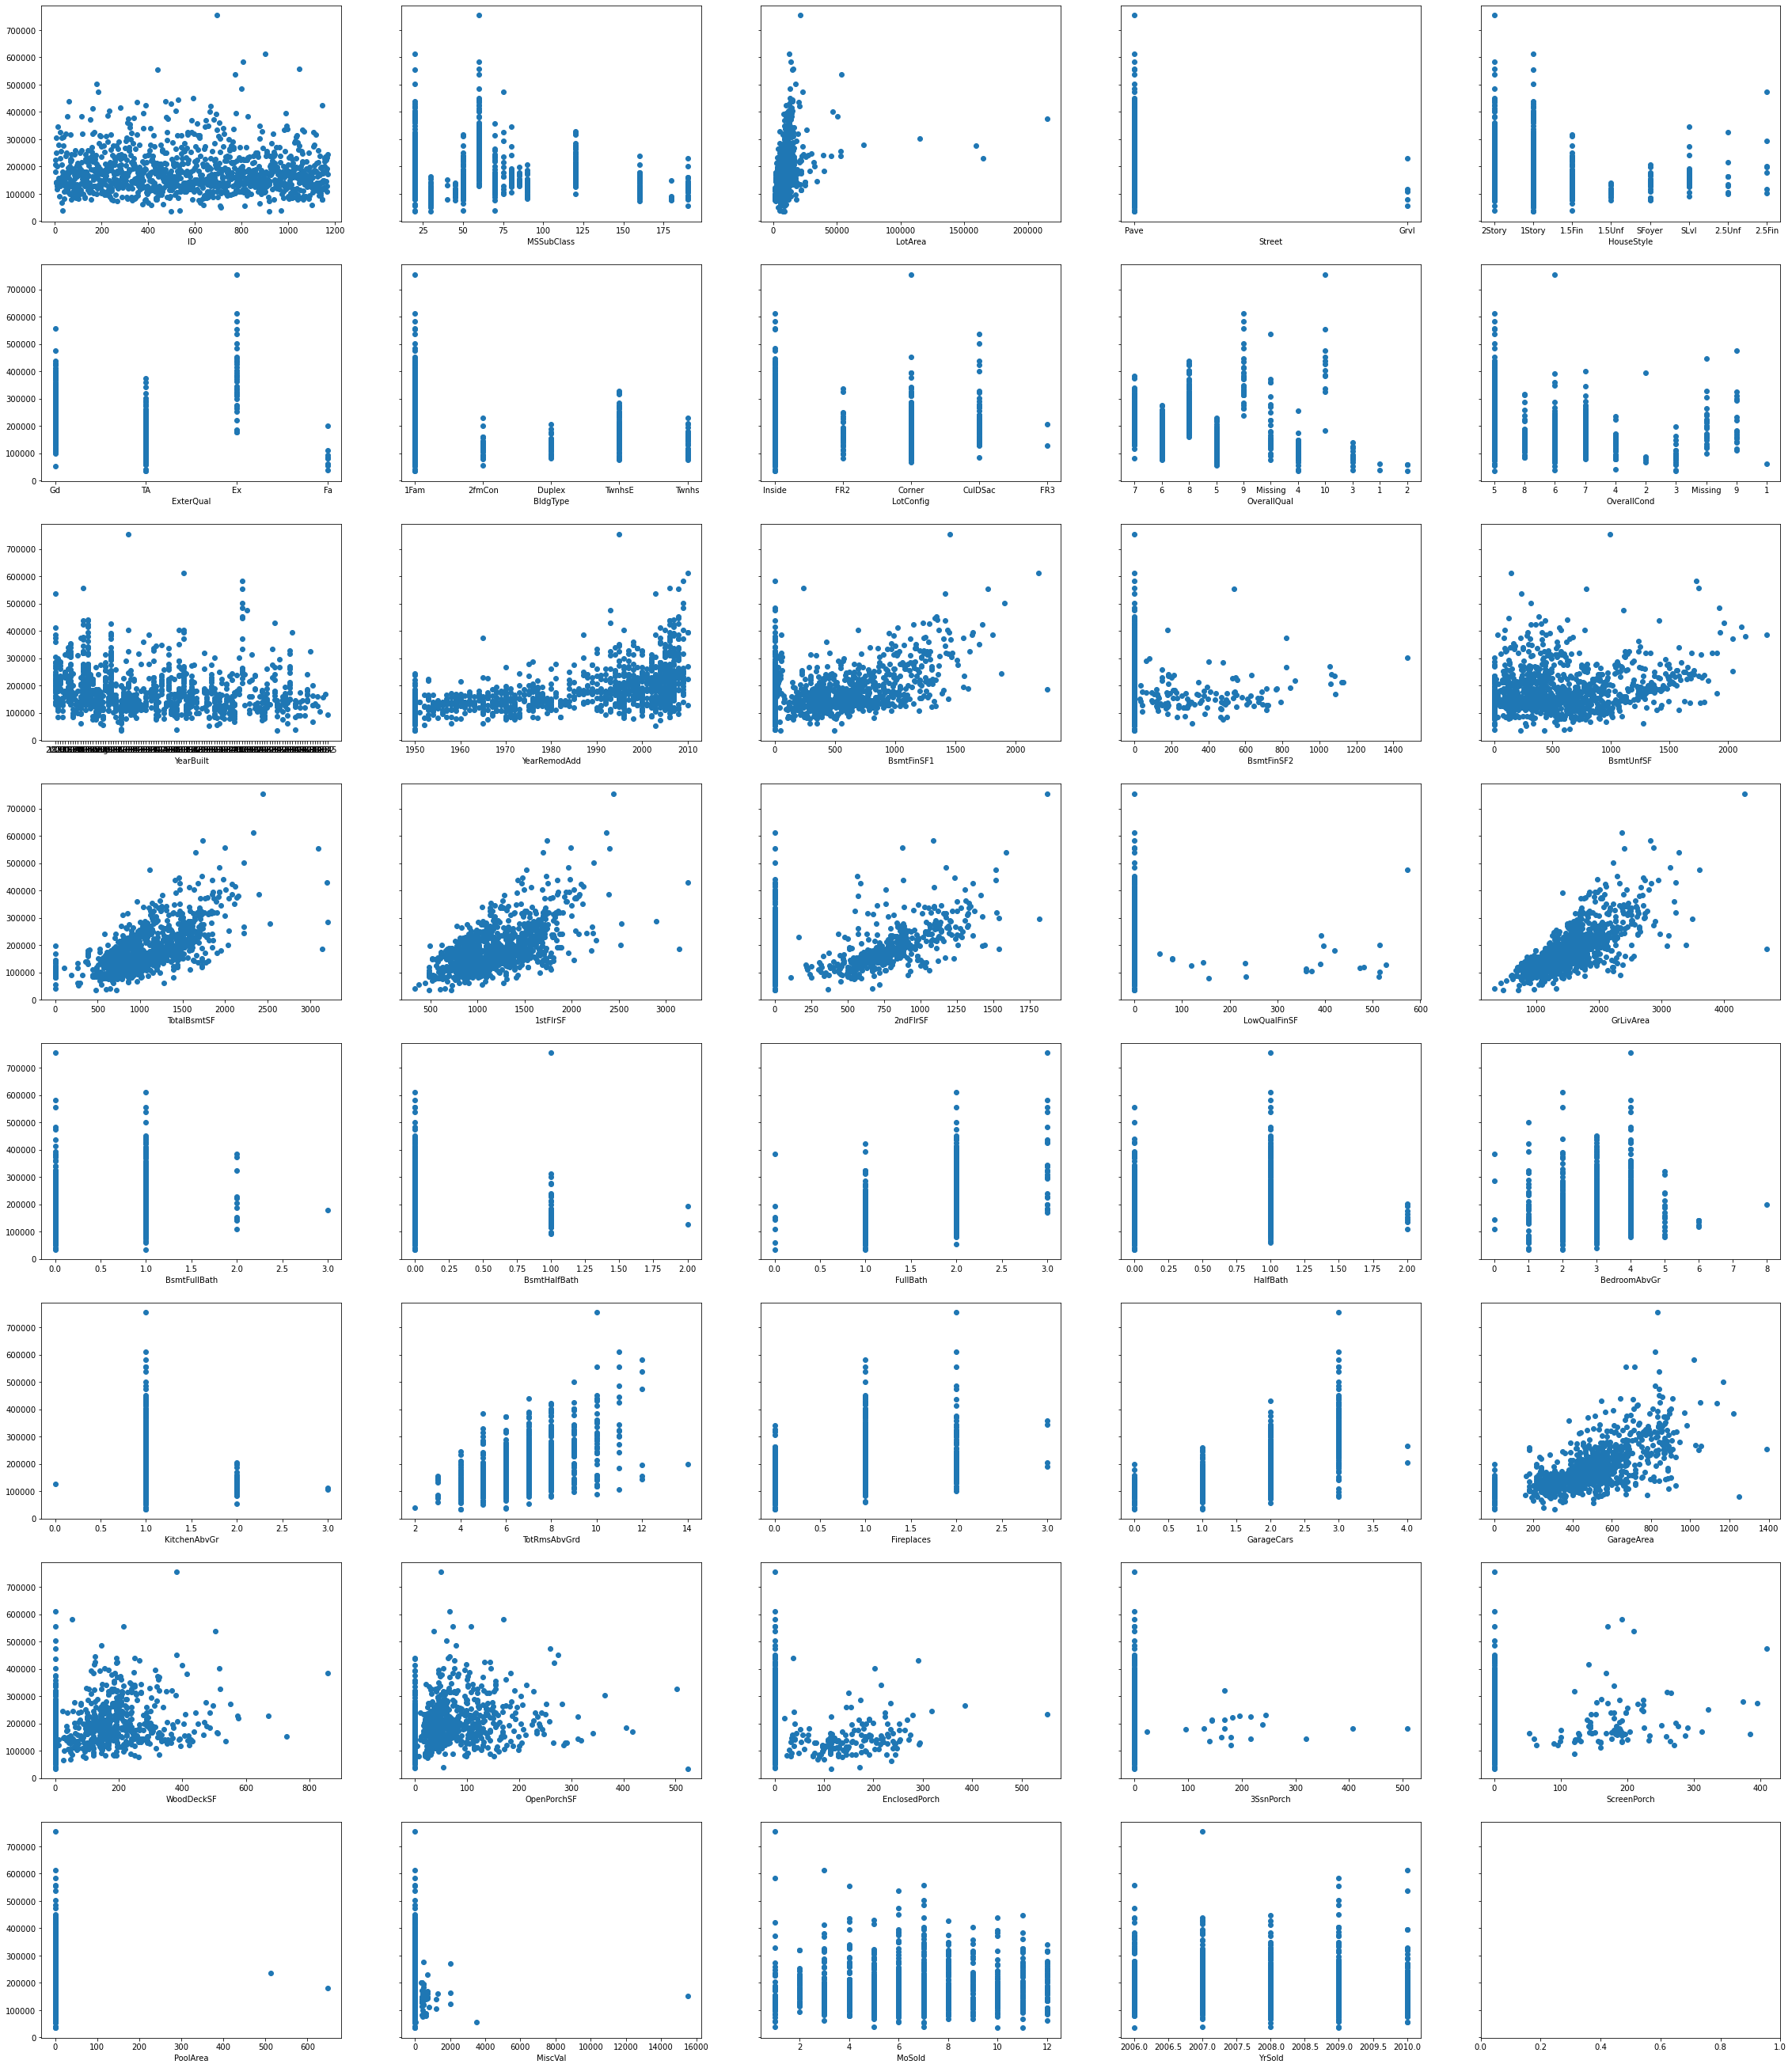

<Figure size 432x288 with 0 Axes>

In [106]:
# Check scatter
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

## 1.4 Inspect skew

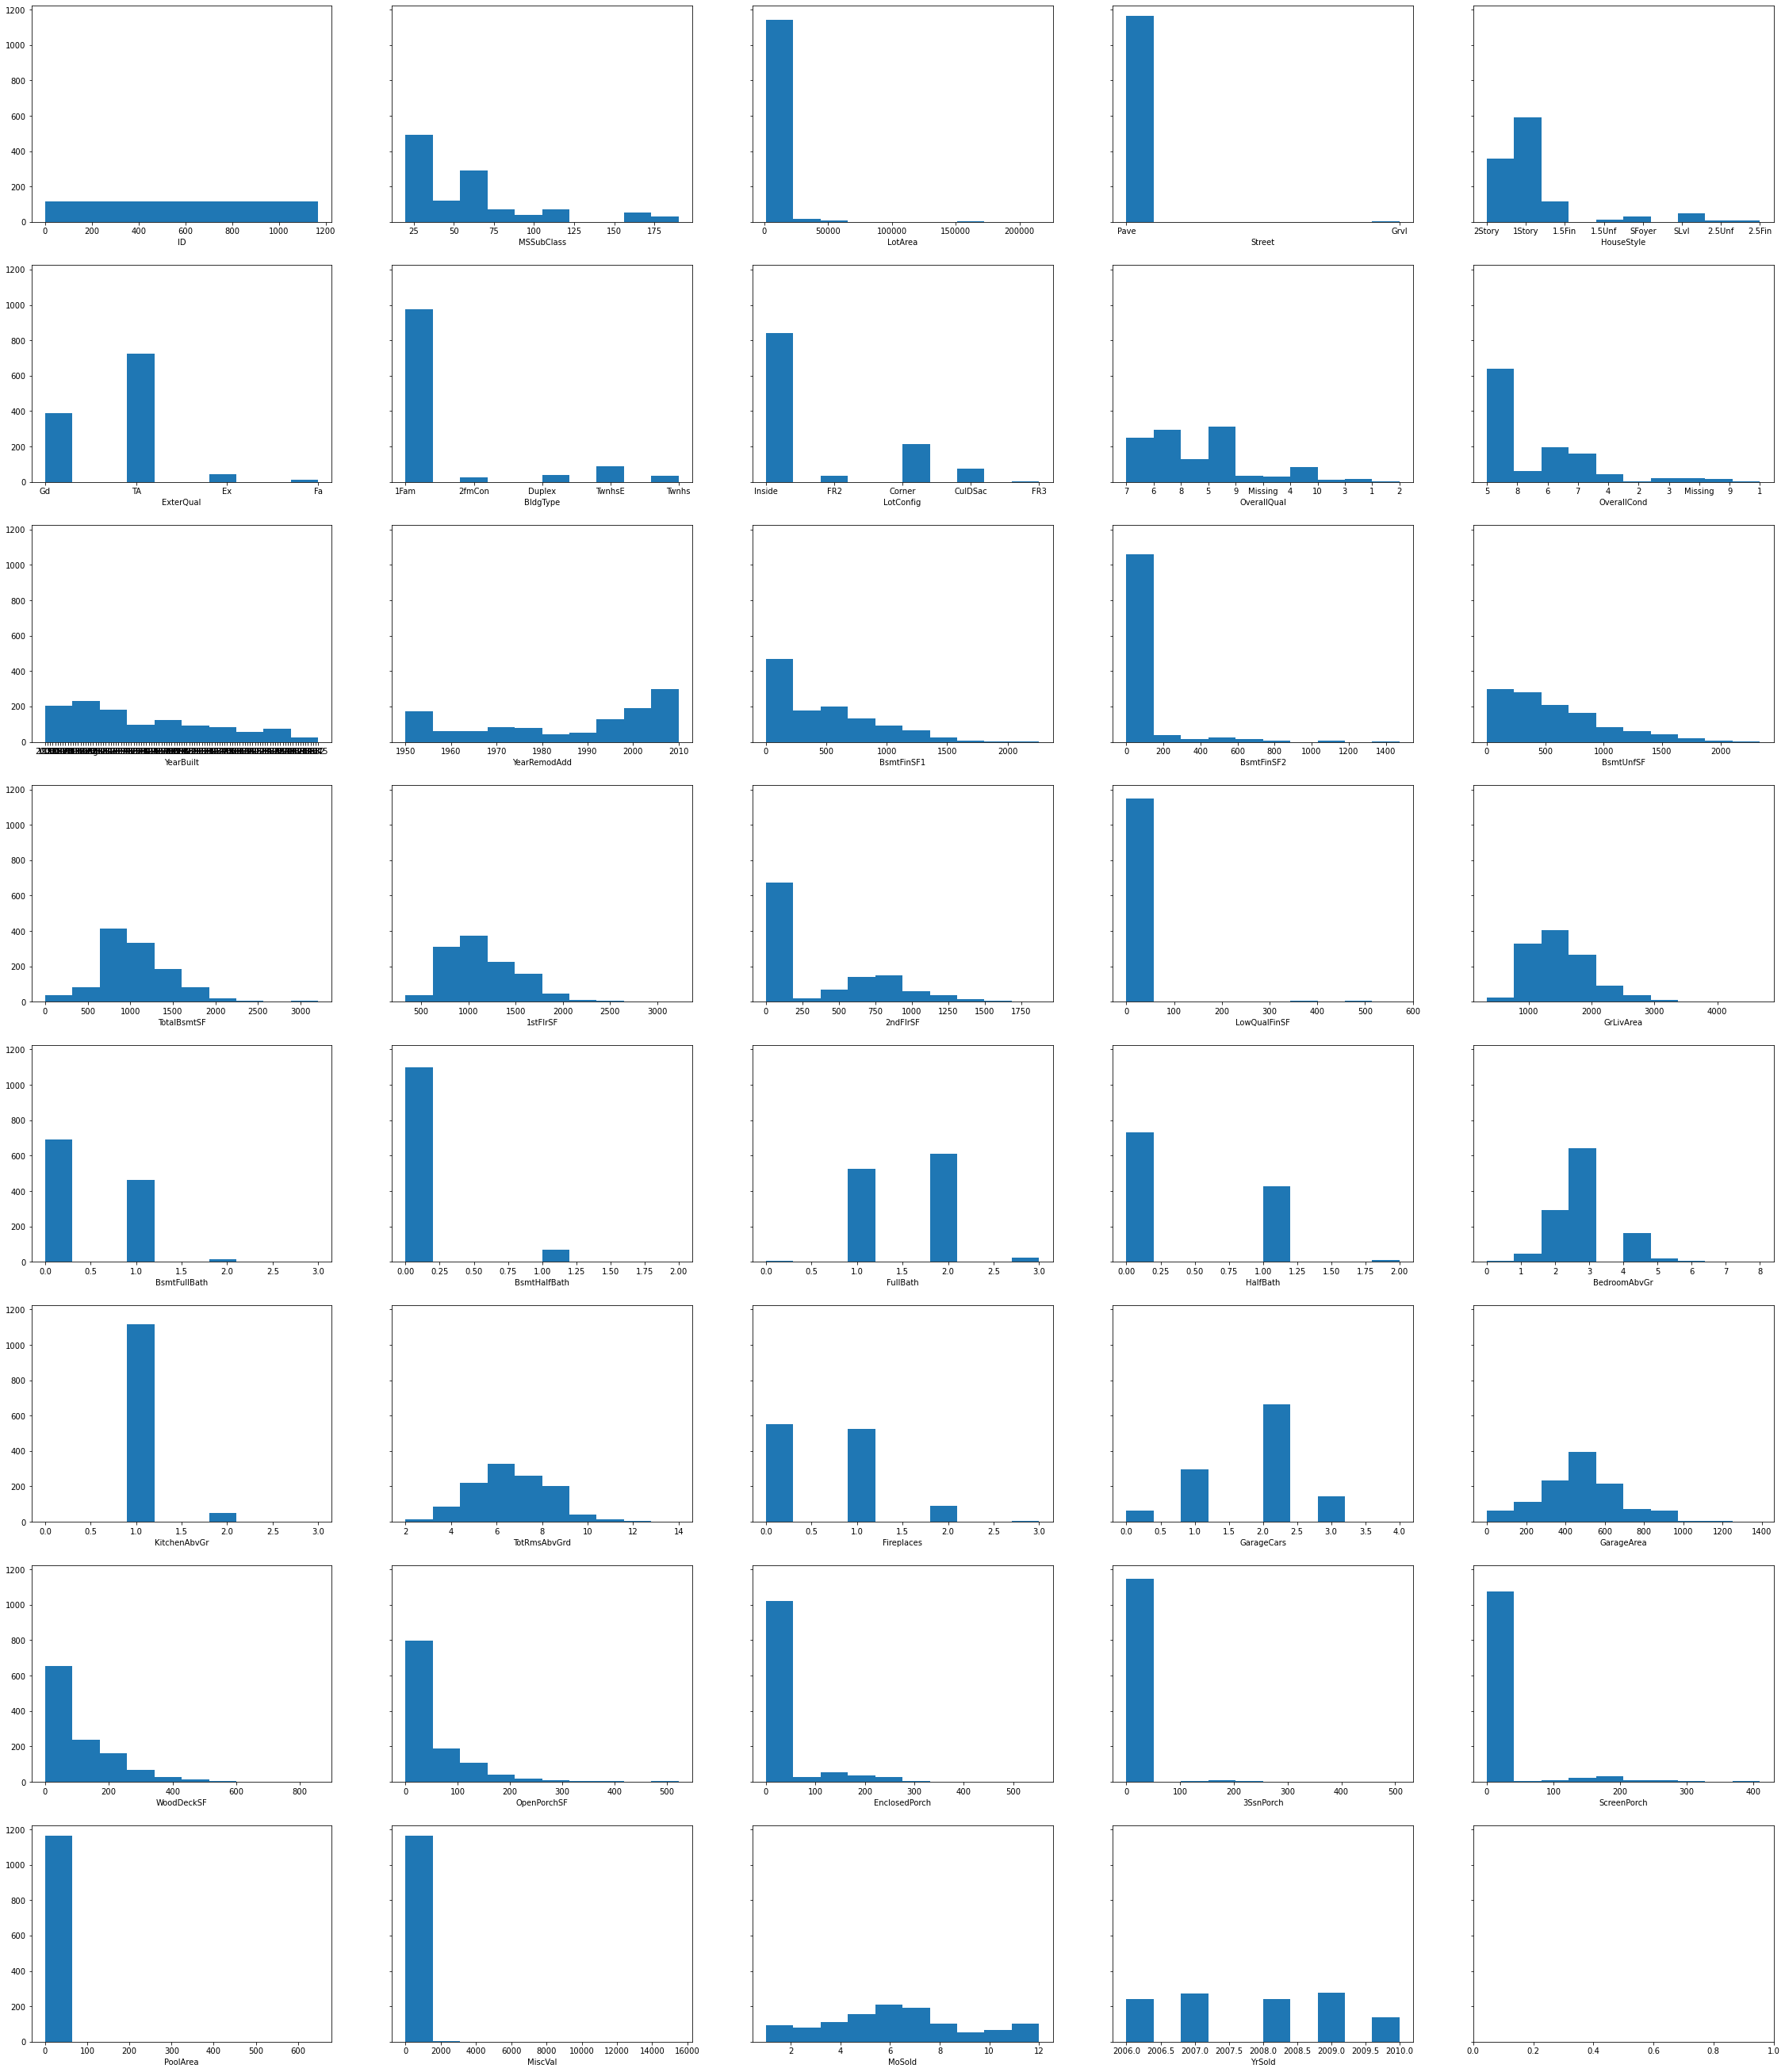

<Figure size 432x288 with 0 Axes>

In [107]:
# Check feature distribution
plot_custom_subplot(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'], plot_type='histogram')

1.7487112596222822


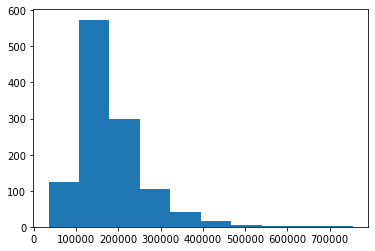

In [108]:
# Check sale price distribution
plt.hist(train_data['SalePrice'])
print(train_data['SalePrice'].skew())


In [109]:
# check skew
# from scipy.stats import shapiro
# print(shapiro(train_data['SalePrice'])) # Formal skew check

num_feats = train_data.dtypes[train_data.dtypes!='object'].index
skew_feats = train_data[num_feats].skew().sort_values(ascending=False)
print(skew_feats)

                    Skew
MiscVal        27.966380
PoolArea       24.623340
LotArea        12.240663
3SsnPorch      10.208476
LowQualFinSF    8.684560
KitchenAbvGr    4.596279
BsmtFinSF2      4.313216
BsmtHalfBath    3.948249
ScreenPorch     3.936139
EnclosedPorch   3.168149
OpenPorchSF     2.292215
SalePrice       1.748711
WoodDeckSF      1.484201
MSSubClass      1.410259
GrLivArea       1.078755
1stFlrSF        0.963637
BsmtUnfSF       0.951956
2ndFlrSF        0.815896
BsmtFinSF1      0.789096
TotRmsAbvGrd    0.672153
HalfBath        0.659175
Fireplaces      0.645413
BsmtFullBath    0.642196
TotalBsmtSF     0.563757
BedroomAbvGr    0.290898
MoSold          0.199846
GarageArea      0.097302
YrSold          0.095714
FullBath        0.048092
ID              0.000000
GarageCars     -0.389608
YearRemodAdd   -0.520319


# 2.Process the data

## 2.1 Impute or drop 'Missing' data

In [110]:
def get_cols_with_missing(dfObj, value:"Missing") -> list:
    """Return list of the columns that equal the value."""

    listCols = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols

train_cols_with_missing = get_cols_with_missing(train_data, "Missing")
print(train_cols_with_missing)

test_cols_with_missing = get_cols_with_missing(test_data, "Missing")
print(test_cols_with_missing)

['OverallCond' 'OverallQual' 'YearBuilt']
['OverallCond' 'OverallQual' 'YearBuilt']


In [111]:
def replace_missing_with_mean(df, cols_with_missing:list):
    """Replace the fields in the dataframe object with the mean of that column."""

    df_copy = df.copy()

    df_copy.replace(to_replace="Missing", value=np.nan, inplace=True)

    # df_object['OverallQual'].mean() didnt' work because data type not number. Write it up in the report.
    # df_object['OverallQual'].dtypes #dtype('O') is a string

    for col in cols_with_missing:
        df_copy[col] = df_copy[col].astype('float') # because NaN is a float and mean() requires same data type
        df_copy[col].fillna(value=df_copy[col].mean(), inplace=True) 
        df_copy[col] = df_copy[col].astype('int') # linear regression only supports int type
    
    return df_copy

In [112]:
def get_rows_with_missing_data(df_object, cols_with_missing:list):
    """Find row if it contains 'Missing' in any of the columns in cols_with_missing."""

    rows_with_missing = []
    for index, row in df_object.iterrows():
        # If the row contains at least one 'Missing' then append to the list
        num_missing = 0
        for col in cols_with_missing:
            if row[col] == 'Missing':
                num_missing += 1
        if num_missing > 0:
            rows_with_missing.append(row)

    return rows_with_missing


In [113]:
train_rows_with_missing = get_rows_with_missing_data(train_data, train_cols_with_missing)
test_rows_with_missing = get_rows_with_missing_data(test_data, test_cols_with_missing)

print(f'Train.csv has {len(train_rows_with_missing)} rows with \'Missing\' data out of {len(train_data)}.')
print(f'Test.csv has {len(test_rows_with_missing)} rows with \'Missing\' data out of {len(test_data)}.')

Train.csv has 66 rows with 'Missing' data out of 1168.
Test.csv has 15 rows with 'Missing' data out of 292.


In [114]:
def drop_rows(df):
    """Drops rows if the columns OverallCond, OverallQual of YearBuilt contain 'Missing'."""
    df_subset = df[(df['OverallCond'] != 'Missing') & (df['OverallQual'] != 'Missing') & (df['YearBuilt'] !='Missing')] 
    return df_subset

In [115]:
def fix_missing_data(df, missing_data_treatment='mean'):
    if missing_data_treatment =='mean': # impute
        cols_with_missing = get_cols_with_missing(df, "Missing")
        df_fixed = replace_missing_with_mean(df, cols_with_missing)
    if missing_data_treatment =='drop':
        df_fixed = drop_rows(df)
    return df_fixed

In [116]:
train_imputed = fix_missing_data(train_data, 'mean')
train_dropped = fix_missing_data(train_data, 'drop')

test_imputed = fix_missing_data(test_data, 'mean')
test_dropped = fix_missing_data(test_data, 'drop')

In [117]:
# Sanity check
print(len(train_imputed))
print(len(train_dropped))

1168
1102


## 2.2 Change dtypes to numerical


In [131]:
def change_dtype(df):
    df = df.astype({'OverallCond': int})
    df = df.astype({'OverallQual': int})
    df = df.astype({'YearBuilt': int})
    return df

In [132]:
train_imputed = change_dtype(train_imputed)
train_dropped = change_dtype(train_dropped)

test_imputed = change_dtype(test_imputed)
test_dropped = change_dtype(test_dropped)

## 2.4 Fix skew

In [135]:
from scipy.stats import boxcox

def unskew(df):
    df_copy = df.copy()
    lmbda_map = {} # store lambda values to later apply on test set
    for col_name, skew_value in skew_feats.iteritems():
        df_copy[col_name] += 1 # boxcox requires strictly > 0. Add 1 like boxcox1p.
        df_copy[col_name], lmbda_value = boxcox(df_copy[col_name], lmbda=None)
        lmbda_map.update({col_name: lmbda_value})
    return df_copy, lmbda_map


In [136]:
train_imputed_unskewed, train_imputed_unskewed_lmbda_map  = unskew(train_imputed)
train_dropped_unskewed, train_dropped_unskewed_lmbda_map = unskew(train_dropped)

C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\scipy\stats\morestats.py:914: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\scipy\optimize\optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


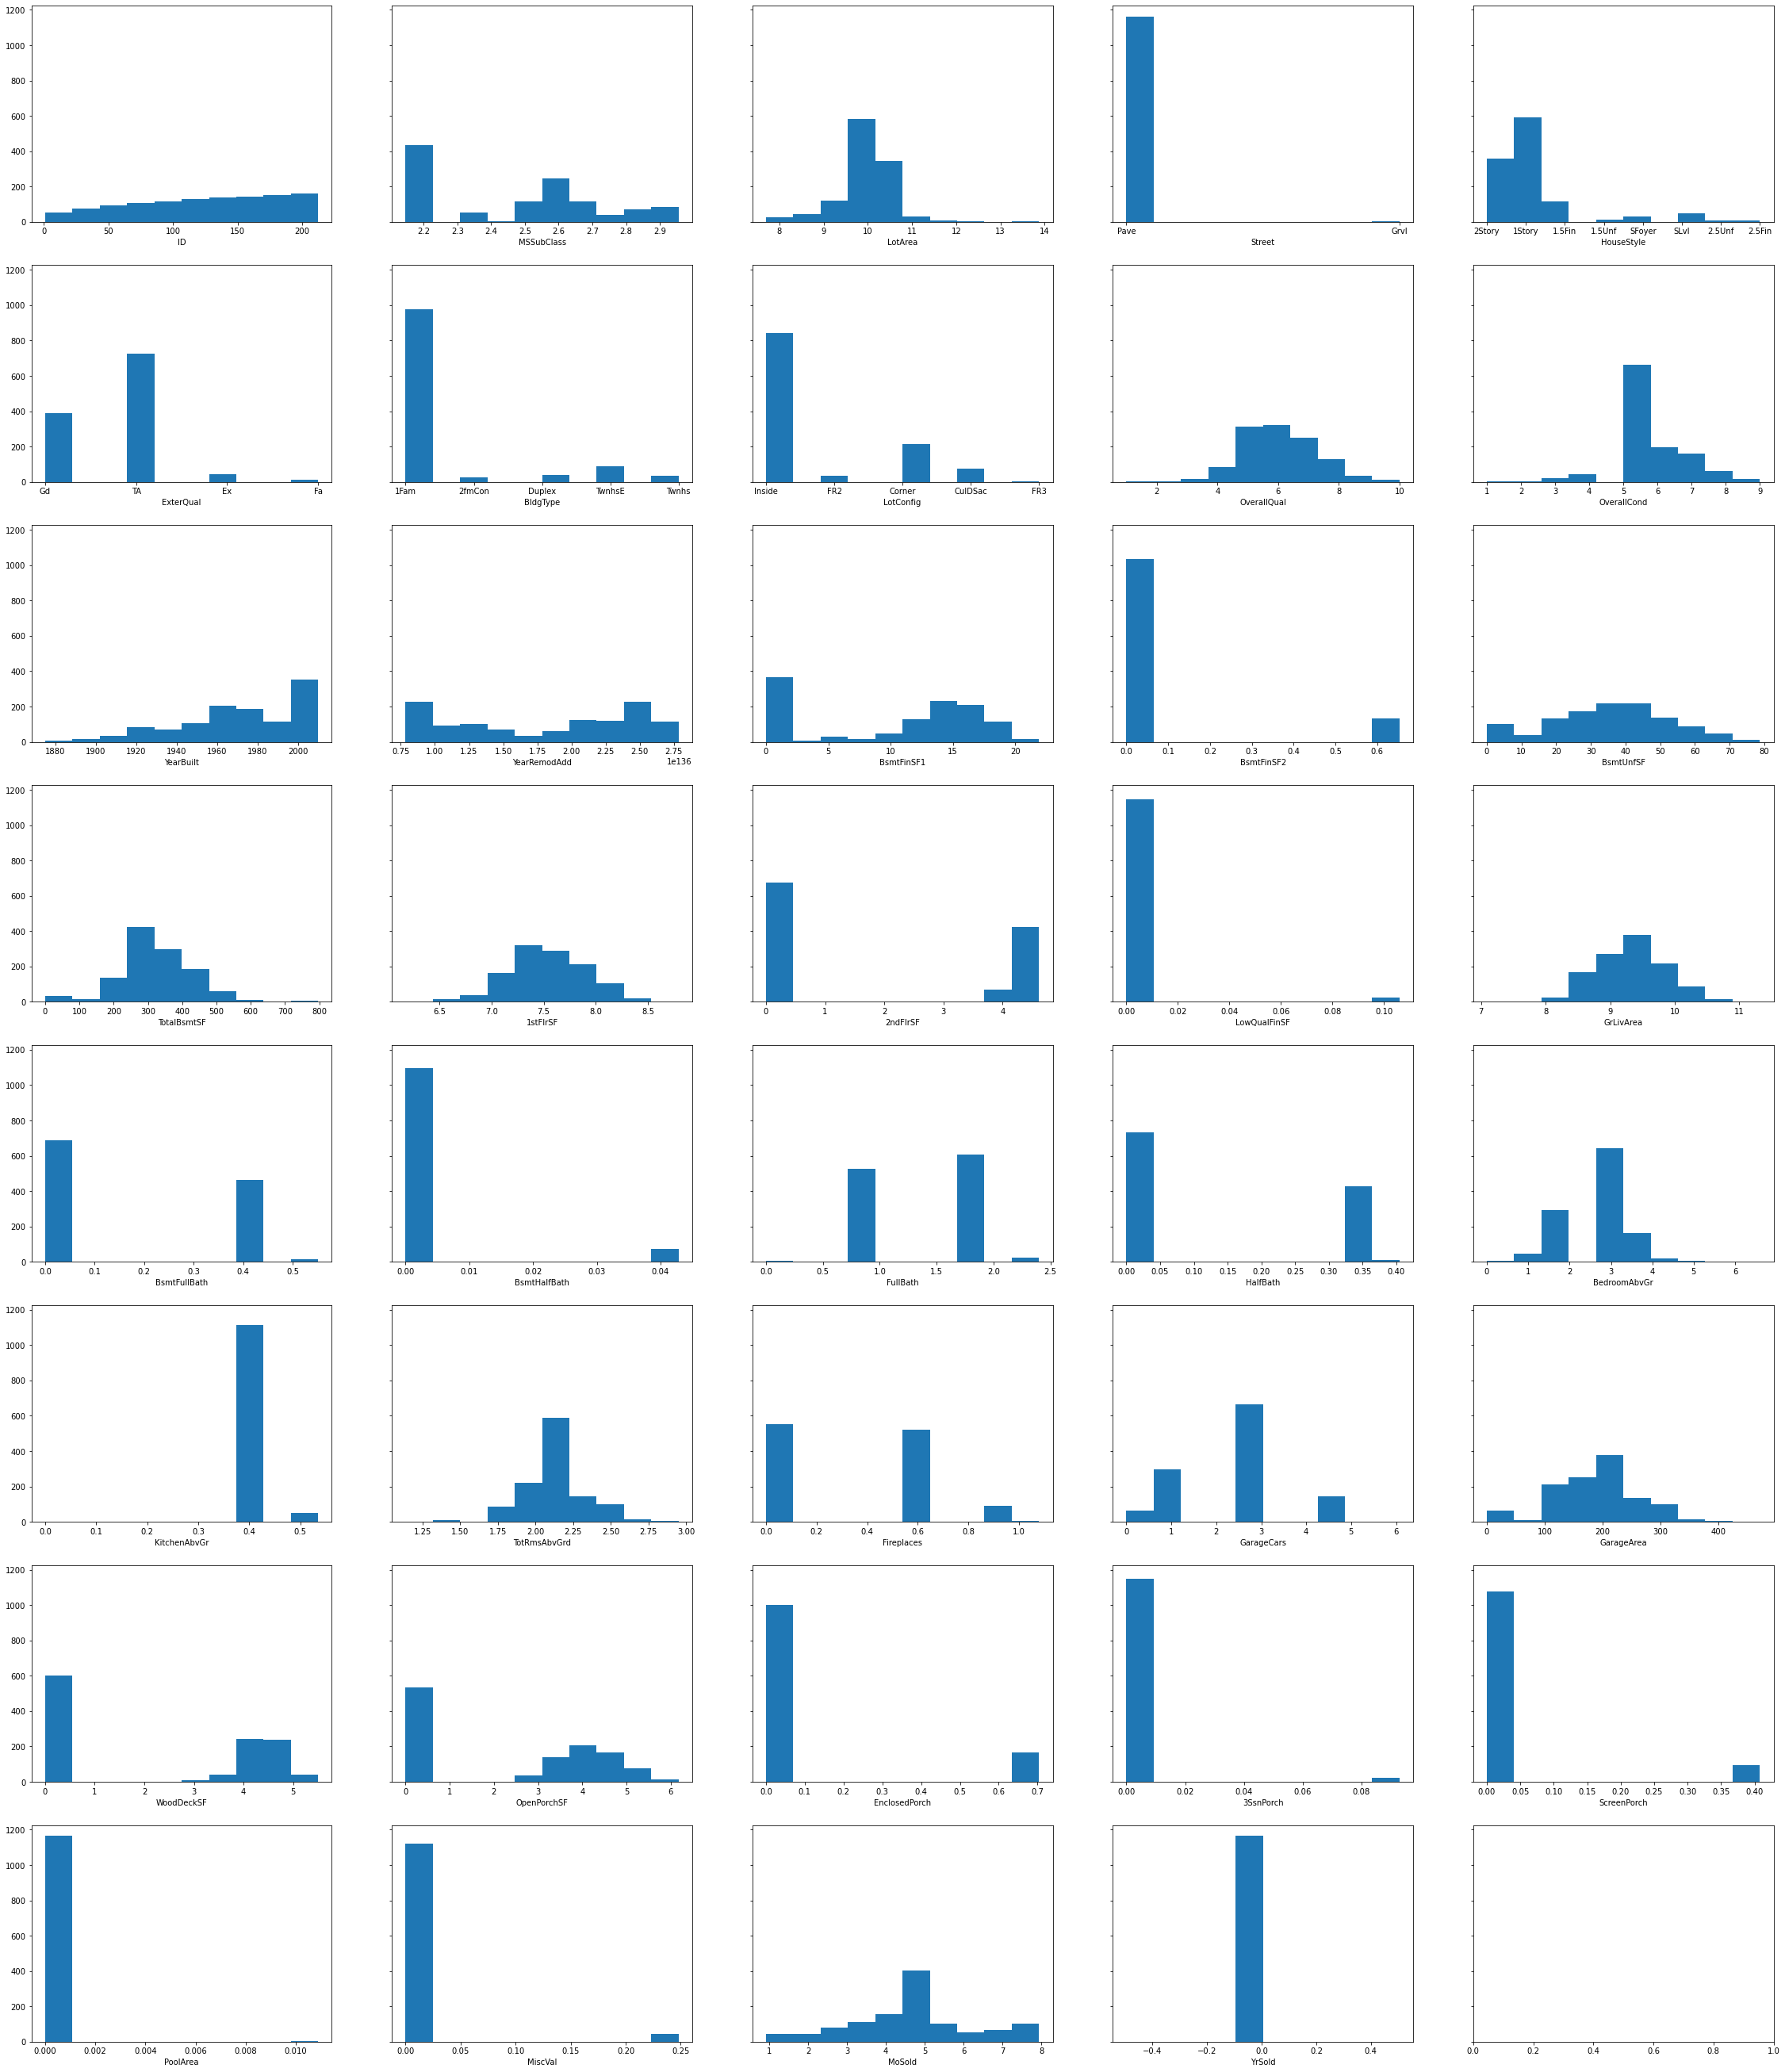

<Figure size 432x288 with 0 Axes>

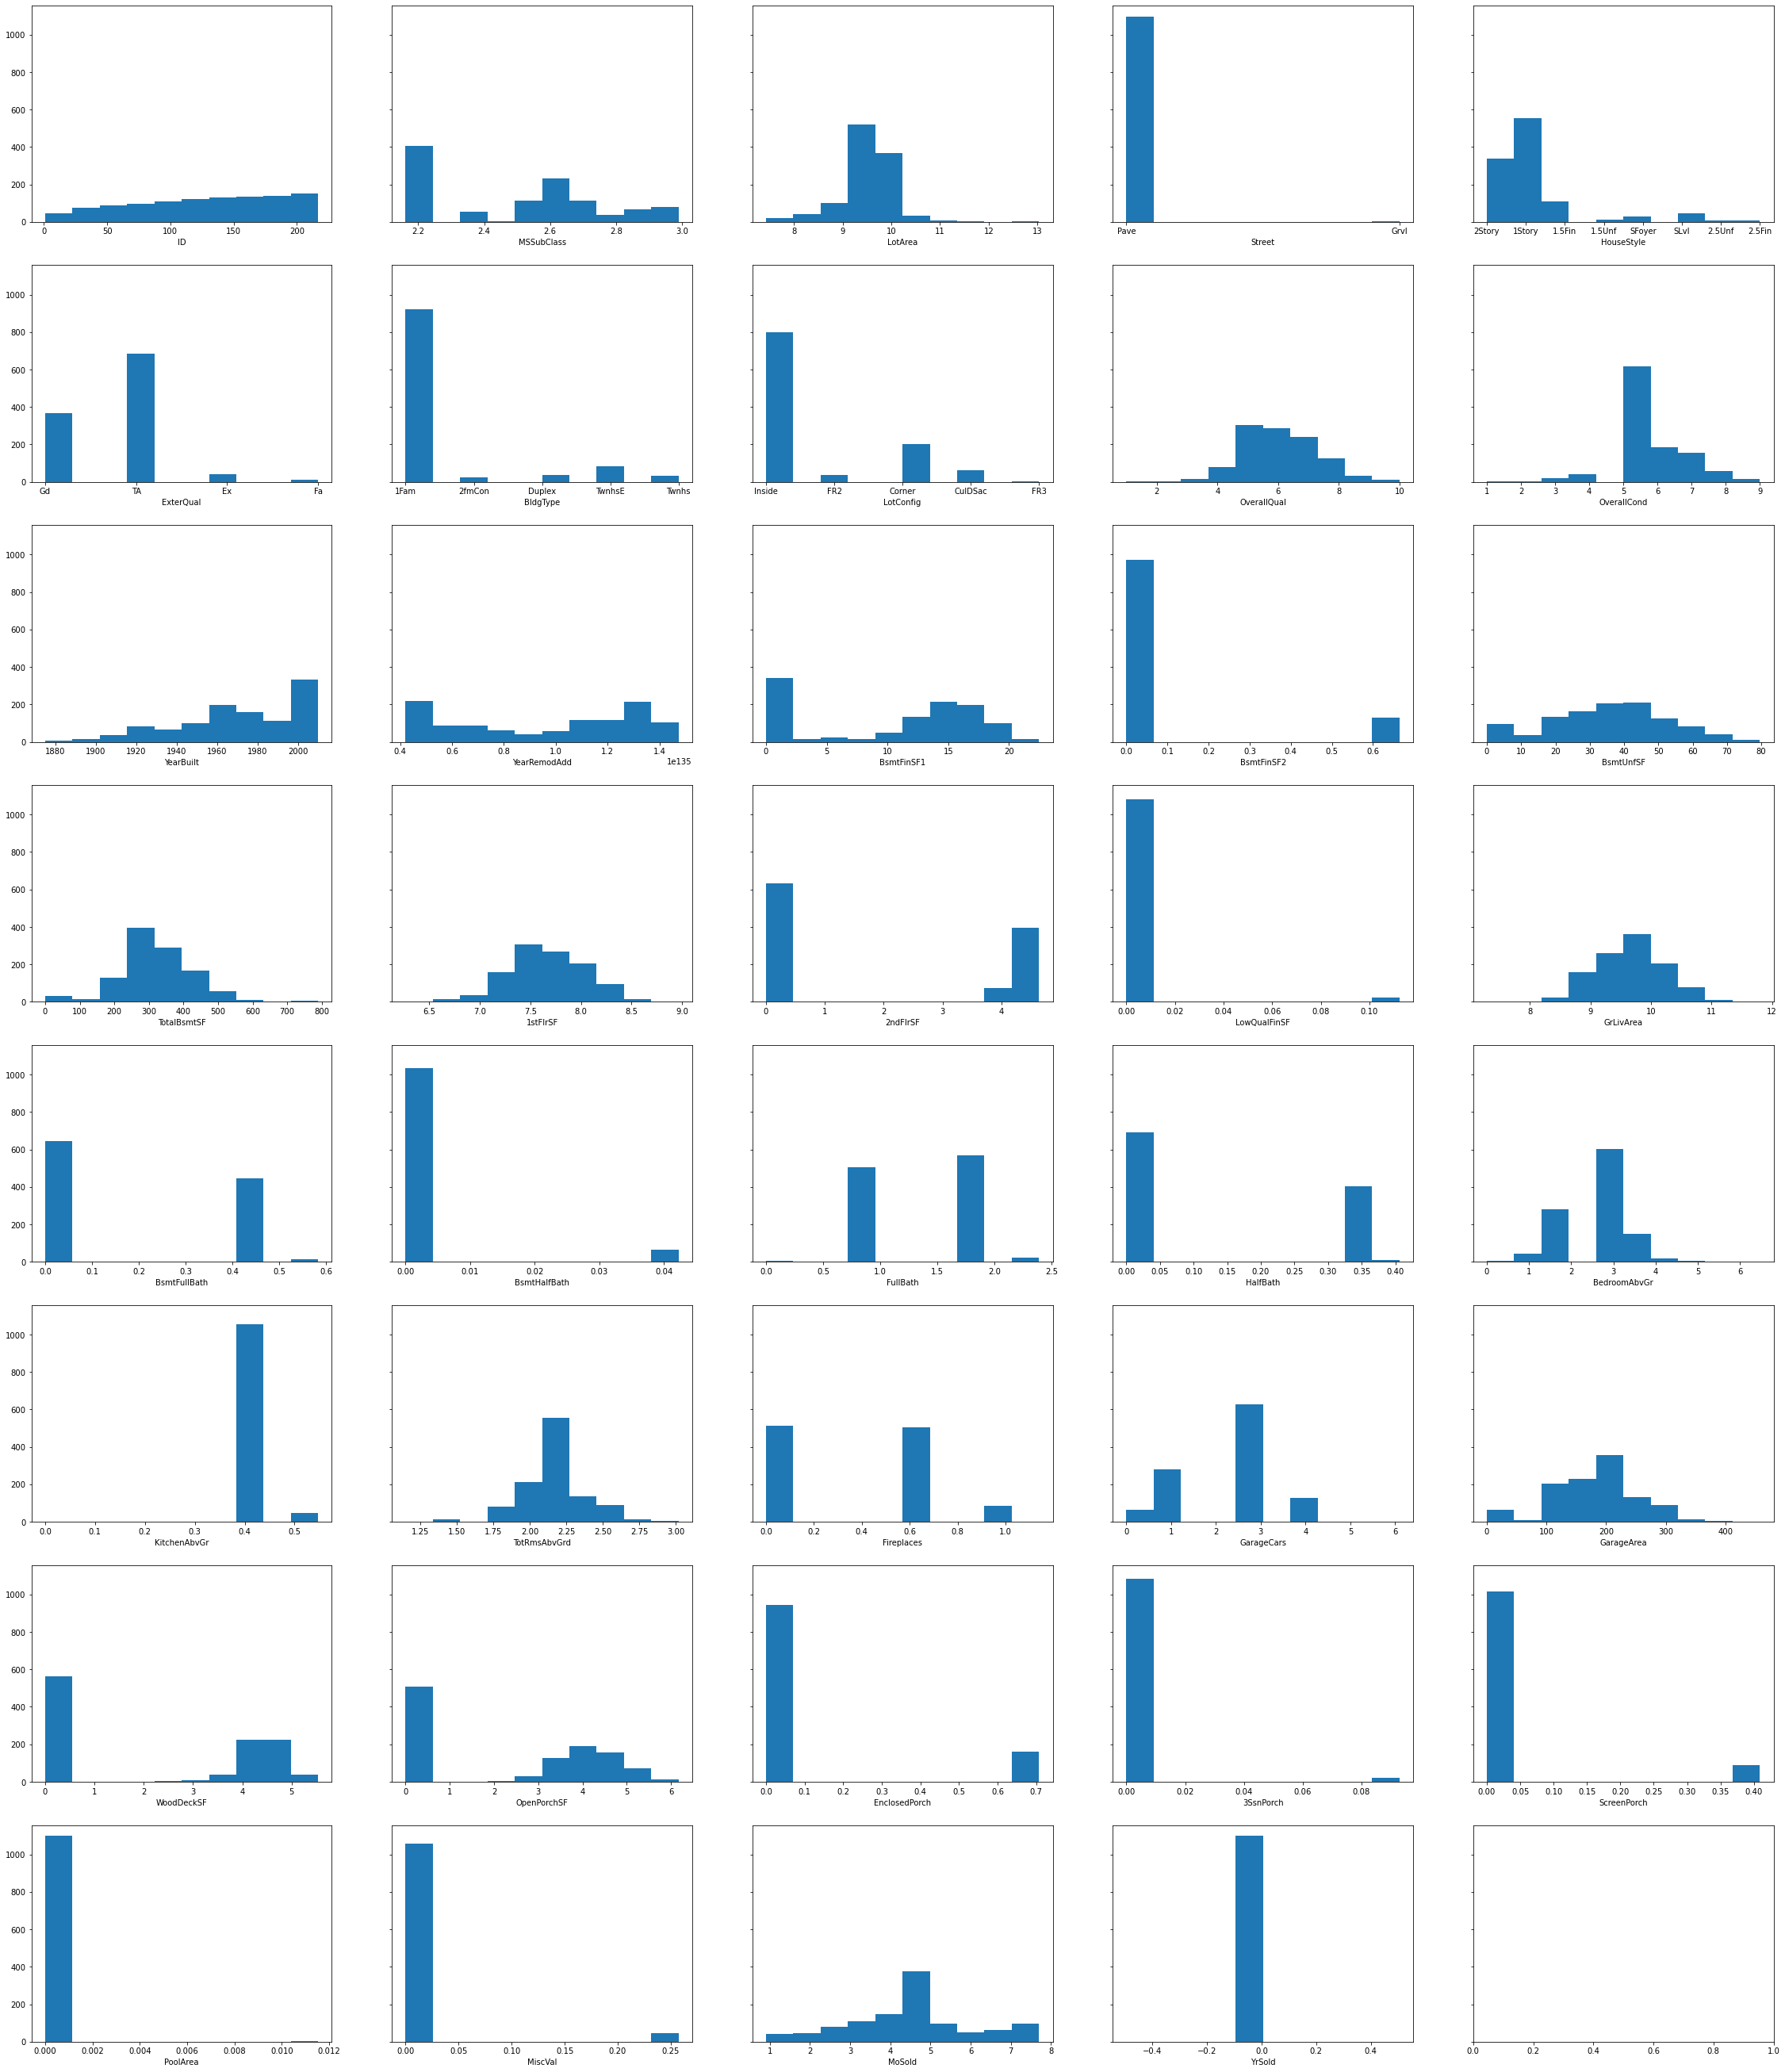

<Figure size 432x288 with 0 Axes>

In [143]:
plot_custom_subplot(train_imputed_unskewed.drop('SalePrice', axis = 1), train_imputed_unskewed['SalePrice'], plot_type='histogram')
plot_custom_subplot(train_dropped_unskewed.drop('SalePrice', axis = 1), train_dropped_unskewed['SalePrice'], plot_type='histogram')

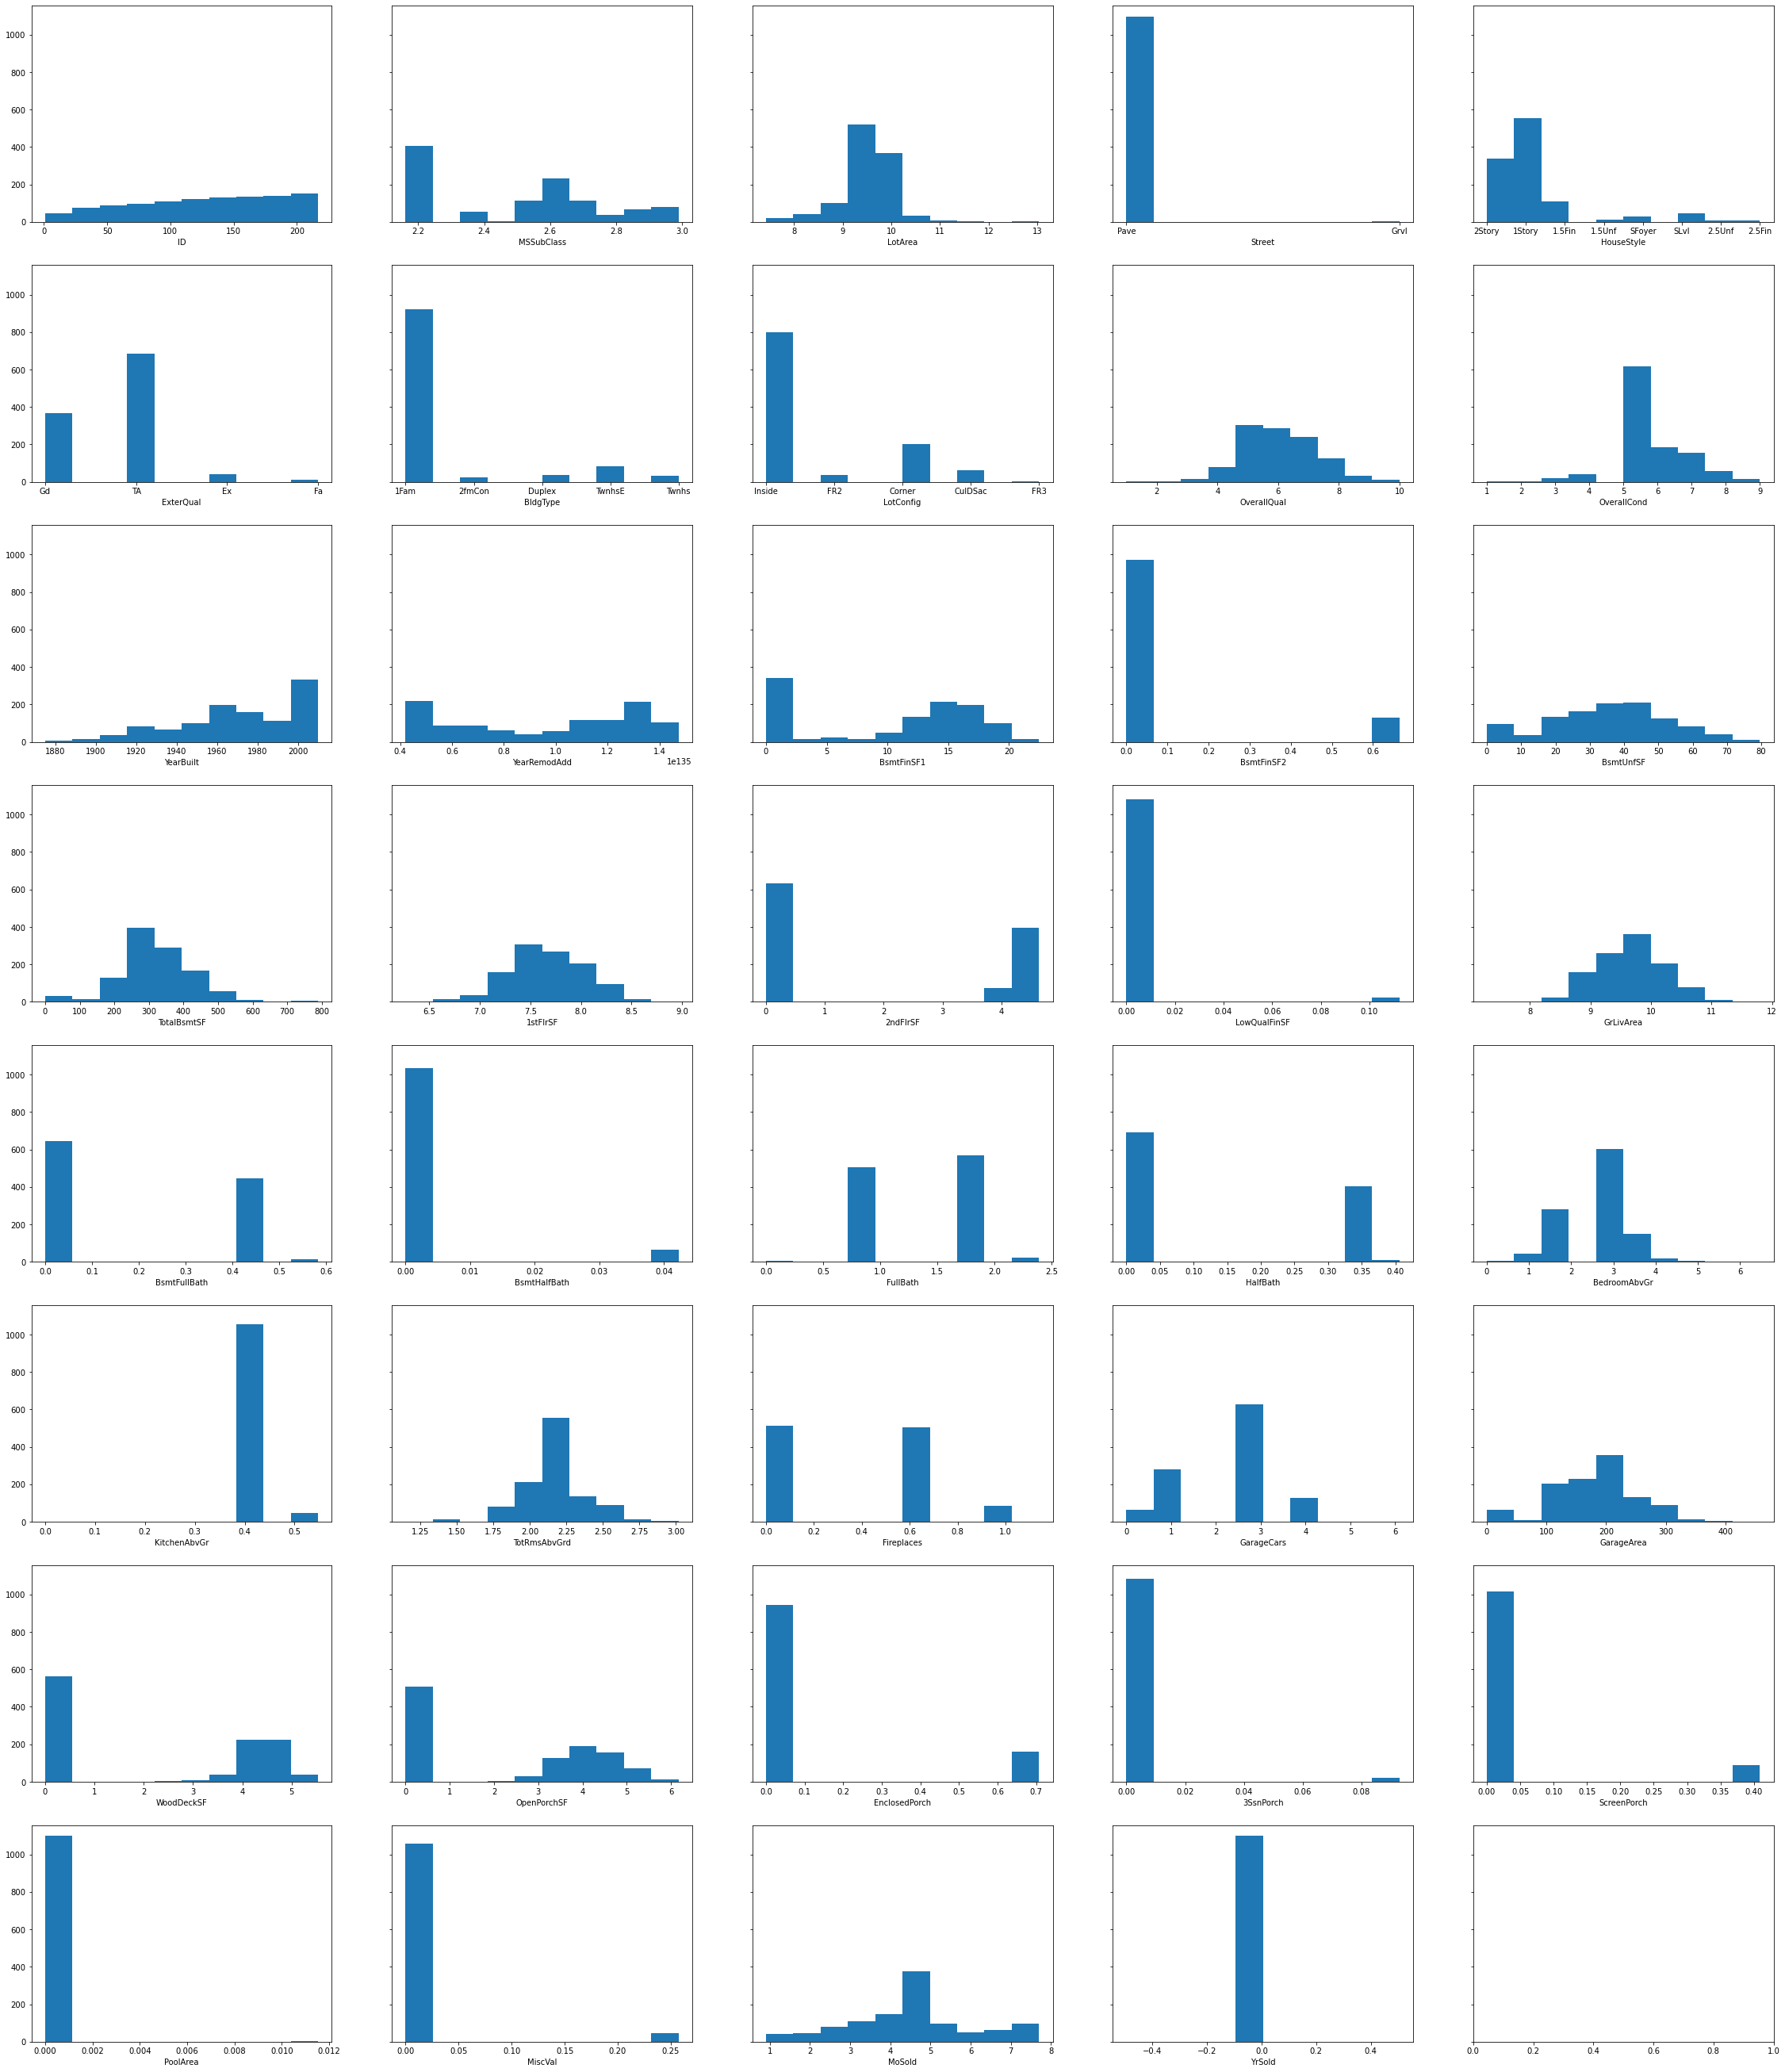

<Figure size 432x288 with 0 Axes>

(array([  5.,   8.,  28., 125., 330., 324., 186.,  75.,  16.,   5.]),
 array([ 8.57364489,  8.76543424,  8.95722359,  9.14901294,  9.34080229,
         9.53259164,  9.72438099,  9.91617034, 10.10795969, 10.29974903,
        10.49153838]),
 <BarContainer object of 10 artists>)

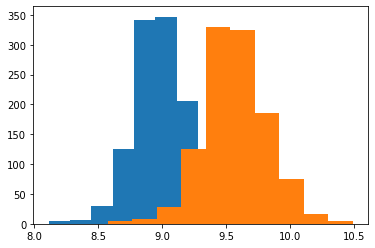

In [142]:
plt.hist(train_imputed_unskewed['SalePrice'])
plt.hist(train_dropped_unskewed['SalePrice'])

## 2.5 Encode categoricals

In [144]:
# Find the columns with 'object' datatypes
def get_categoricals(dataframe) -> list:
    categoricals = []
    for col in dataframe.columns:
        if dataframe[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

In [147]:
# Apply one hot encoding to categoricals.

def one_hot_encode(df, categoricals:list):
    """Dropping categoricals and concatenating one hot encoding."""

    df_copy = df.copy()
    for idx, category in enumerate(categoricals):
        variables_list = df[category].unique()
        print(f'category: {category}: {variables_list}')
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(df_copy[category], drop_first=set_arg)
        df_copy = pd.concat([df_copy, dummy1], axis=1).drop(category, axis=1)
    return df_copy


In [150]:
def encode_categoricals(data):

    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals)

    return data

In [151]:
train_imputed_unskewed_encoded  = encode_categoricals(train_imputed_unskewed)
train_dropped_unskewed_encoded = encode_categoricals(train_dropped_unskewed)

train_imputed_encoded  = encode_categoricals(test_imputed)
train_dropped_encoded = encode_categoricals(test_dropped)

category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' 'SLvl' '1Story' '1.5Fin' '2.5Unf' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']
category: Street: ['Pave']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '2.5Unf' 'SLvl' 'SFoyer' '2.5

## 2.6 Split train, test

In [ ]:
def split_train_test(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df['SalePrice']
    return X, y

# Do Linear Regression

In [ ]:
# Do Linear regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn import linear_model
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

def run_lin_regression(X_train, y_train, X_test, y_test, wrapped=False):
    # Create linear regression object (Ordinary Least Squares)
    models = dict(
        ols=linear_model.LinearRegression(), 
        ridge=linear_model.Ridge(alpha=0.1),
        huber= linear_model.HuberRegressor(max_iter=10000),
        ransac =linear_model.RANSACRegressor(random_state=0),
        theil_sen= linear_model.TheilSenRegressor()
    )

    result = []
    for name, model in models.items():
        print(f'\nRunning {name} regression.')
        if wrapped == True:
            pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', model)])
            wrapped_model = compose.TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
            wrapped_model.fit(X_train, y_train)
            y_predicted = wrapped_model.predict(X_test)
        else:
            # Train the model using the training sets
            model.fit(X_train, y_train)
            # Make predictions using the testing set
            y_predicted = model.predict(X_test)

        # Evaluate
        # The coefficients
        # print("Coefficients: \n", reg.coef_)
        # The mean squared error
        mse = mean_squared_error(y_test, y_predicted)
        print("Mean squared error: %.3f" % mse)
        # The coefficient of determination: 1 is perfect prediction
        r2 = r2_score(y_test, y_predicted)
        print("Coefficient of determination: %.3f" % r2)
        result.append((y_predicted, mse, r2, name))
    return result



In [ ]:
def plot_predictions(result, y_test, data_in='no_mods'):

    num_plots = len(result)
    num_rows = 1
    fig, ax_array =  plt.subplots(num_rows, num_plots, figsize=(100/2.54, 10/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        # Unpack
        y_predict = result[k][0]
        r2 = result[k][2]
        model_name = result[k][3]

        ax_row.set_xlabel(model_name + ' R2:' + str(round(r2, 3)))
        ax_row.scatter(y_predict, y_test)
        k += 1
        if k == num_plots:
            break
    
    plt.show()    
    plt.savefig('predictions_vs_test' + data_in + '.png', format='png')
    

In [ ]:
round(0.2333, 2)

0.23

In [ ]:
X_train, y_train = prepare_data(train_data, missing_data_treatment='drop')
X_test, y_test = prepare_data(test_data, missing_data_treatment='drop')
result = run_lin_regression(X_train, y_train, X_test, y_test)

category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: Street: ['Pave']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '2.5Unf' 'SLvl' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']

Running ols regression.
Mean squared error: 39788745081.550
Coefficient of determination: -4.801

Running ridge regression.
Mean squared error: 39788526971.382
Coefficient of determination: -4.801

Running huber regression.
Mean squared error: 40154895679.553
Coefficient of determination: -4.855

Running ransac regression.


C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jason\anaconda3\envs\uni_adelaide_torch\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).

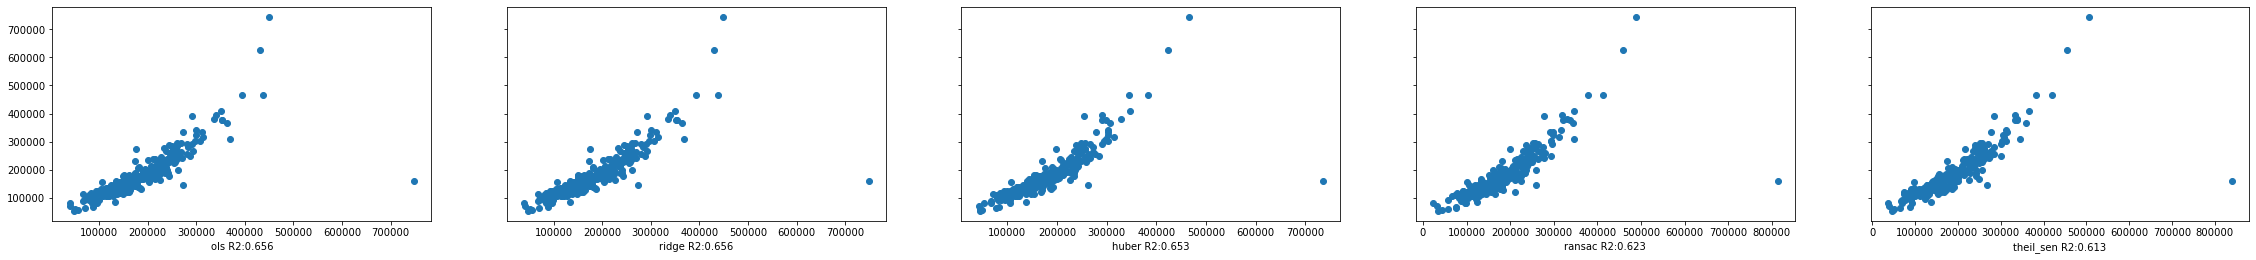

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_predictions(result, y_test, data_in='No_mods')


# Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

TEchnique 1: drop the missing valus
technique 2: fill the missing values if you know them. No I don't
Technique 3: fill missing values with the mean of that column

# Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

# Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [ ]:
# drop ID because it contains no information about the house
# drop MSsubclass because the that information is repeated in the categoricals anyway with more fidelity
# drop MoSold - assume no seasonal price trends
# drop MiscVal - seems immaterial
# drop Fireplaces - seems incidental to the house sale

# query is sale price adjusted for inflation?

columns_to_drop = ['ID', 'MSSubClass', 'MoSold', 'MiscVal', 'Fireplaces']

def create_data_subset(X_train, X_test, columns_to_drop):
    X_train_subset = X_train.copy()
    X_test_subset = X_test.copy()

    for column in columns_to_drop:
        X_train_subset = X_train_subset.drop([column], axis=1)
        X_test_subset = X_test_subset.drop([column], axis=1)
    return X_train_subset, X_test_subset

X_train_subset, X_test_subset = create_data_subset(X_train, X_test, columns_to_drop)

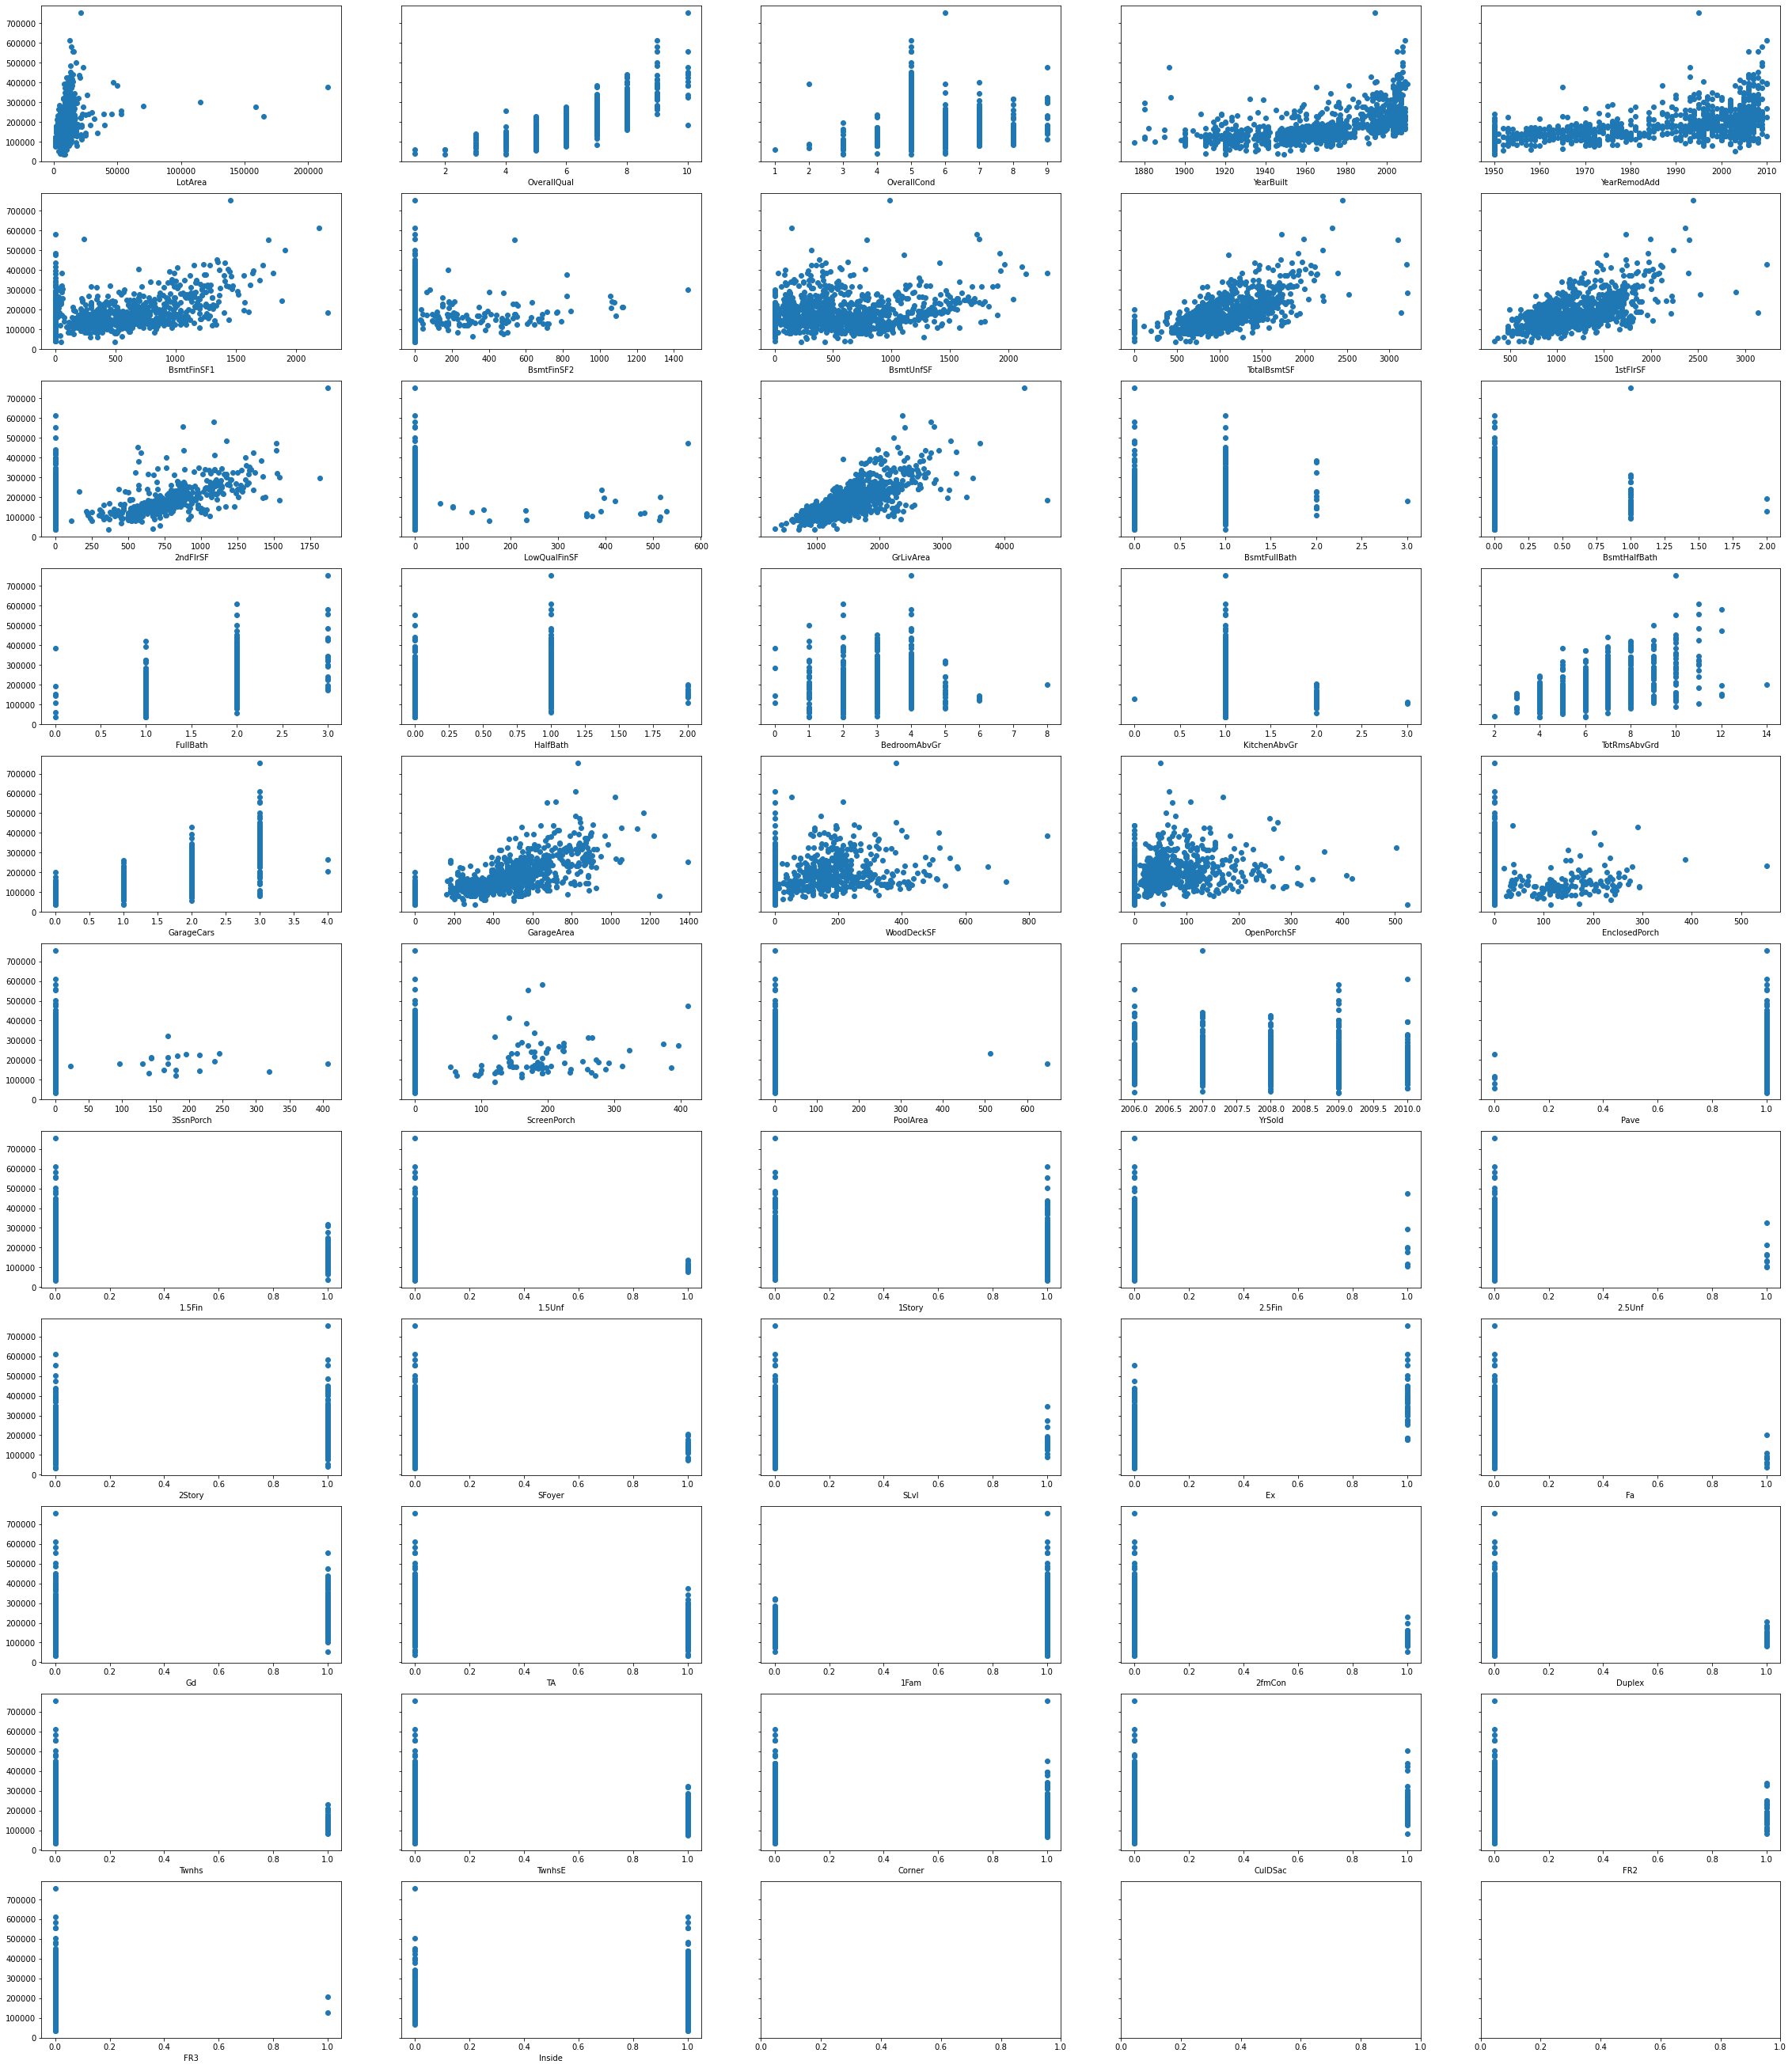

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_custom_subplot(X_train_subset, y_train)

<AxesSubplot:>

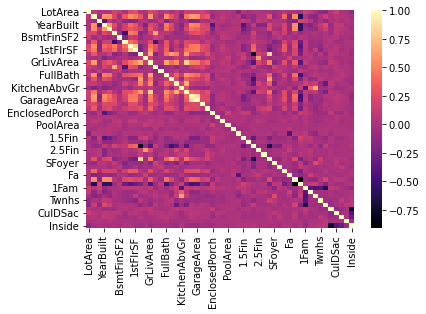

In [ ]:
sb.heatmap(X_train_subset.corr(), cmap = 'magma')


Running ols regression.
Mean squared error: 2359580804.226
Coefficient of determination: 0.656

Running ridge regression.
Mean squared error: 2359654039.367
Coefficient of determination: 0.656

Running huber regression.
Mean squared error: 2409055053.835
Coefficient of determination: 0.649

Running ransac regression.
Mean squared error: 2854010294.791
Coefficient of determination: 0.584

Running theil_sen regression.
Mean squared error: 2703238619.582
Coefficient of determination: 0.606


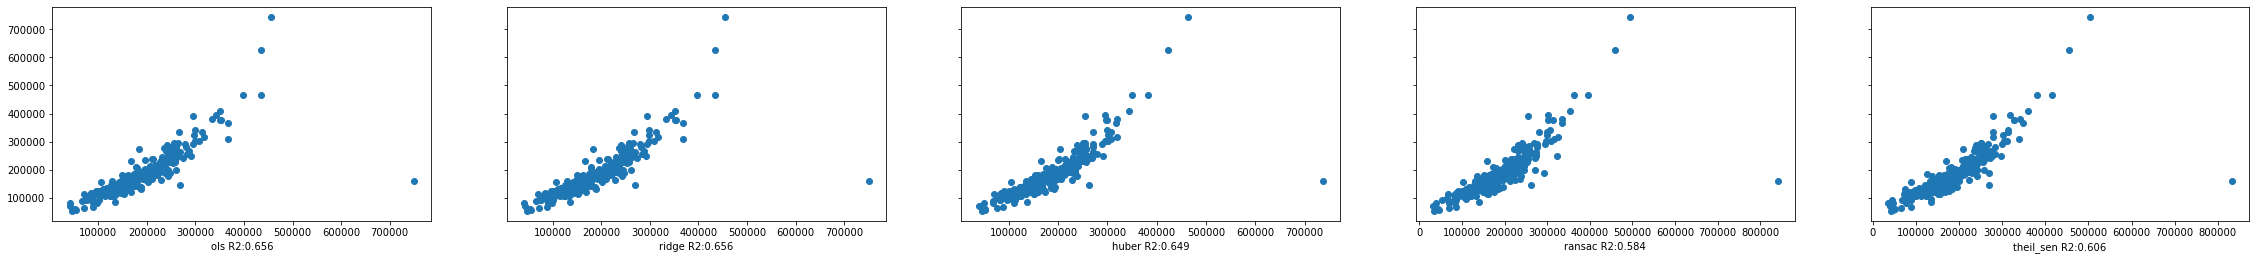

<Figure size 432x288 with 0 Axes>

In [ ]:
result = run_lin_regression(X_train_subset, y_train, X_test_subset, y_test)
plot_predictions(result, y_test, data_in='dropped_unscaled')

# Check unscaled data

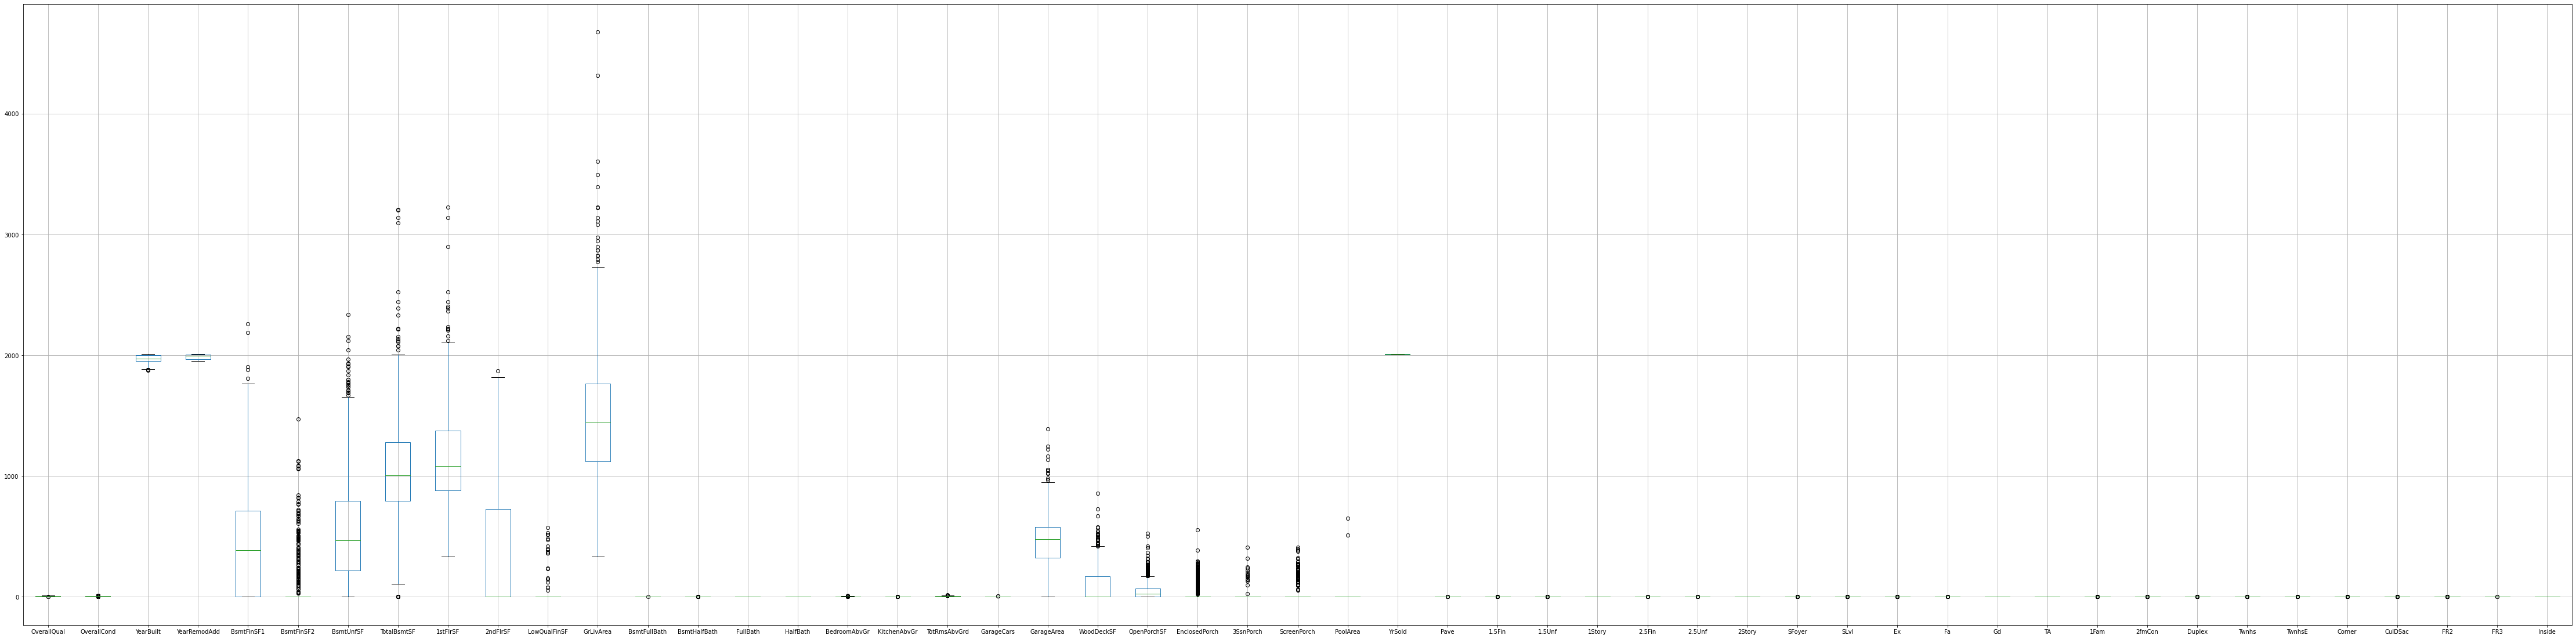

In [ ]:
boxplot = X_train_subset.drop(["LotArea"], axis=1).boxplot(figsize=(200/2.54, 50/2.54))

{'whiskers': [<matplotlib.lines.Line2D at 0x1c73ee8a6c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c73f0e2e88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c73ee8a048>],
 'medians': [<matplotlib.lines.Line2D at 0x1c73ed37648>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c73ed37fc8>],
 'means': []}

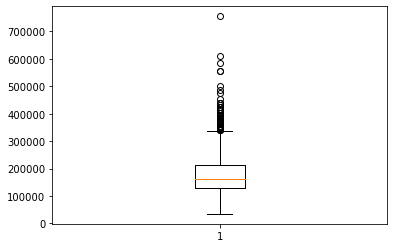

In [ ]:
plt.boxplot(y_train)

# Apply scaling to features and target

(-20.0, 20.0)

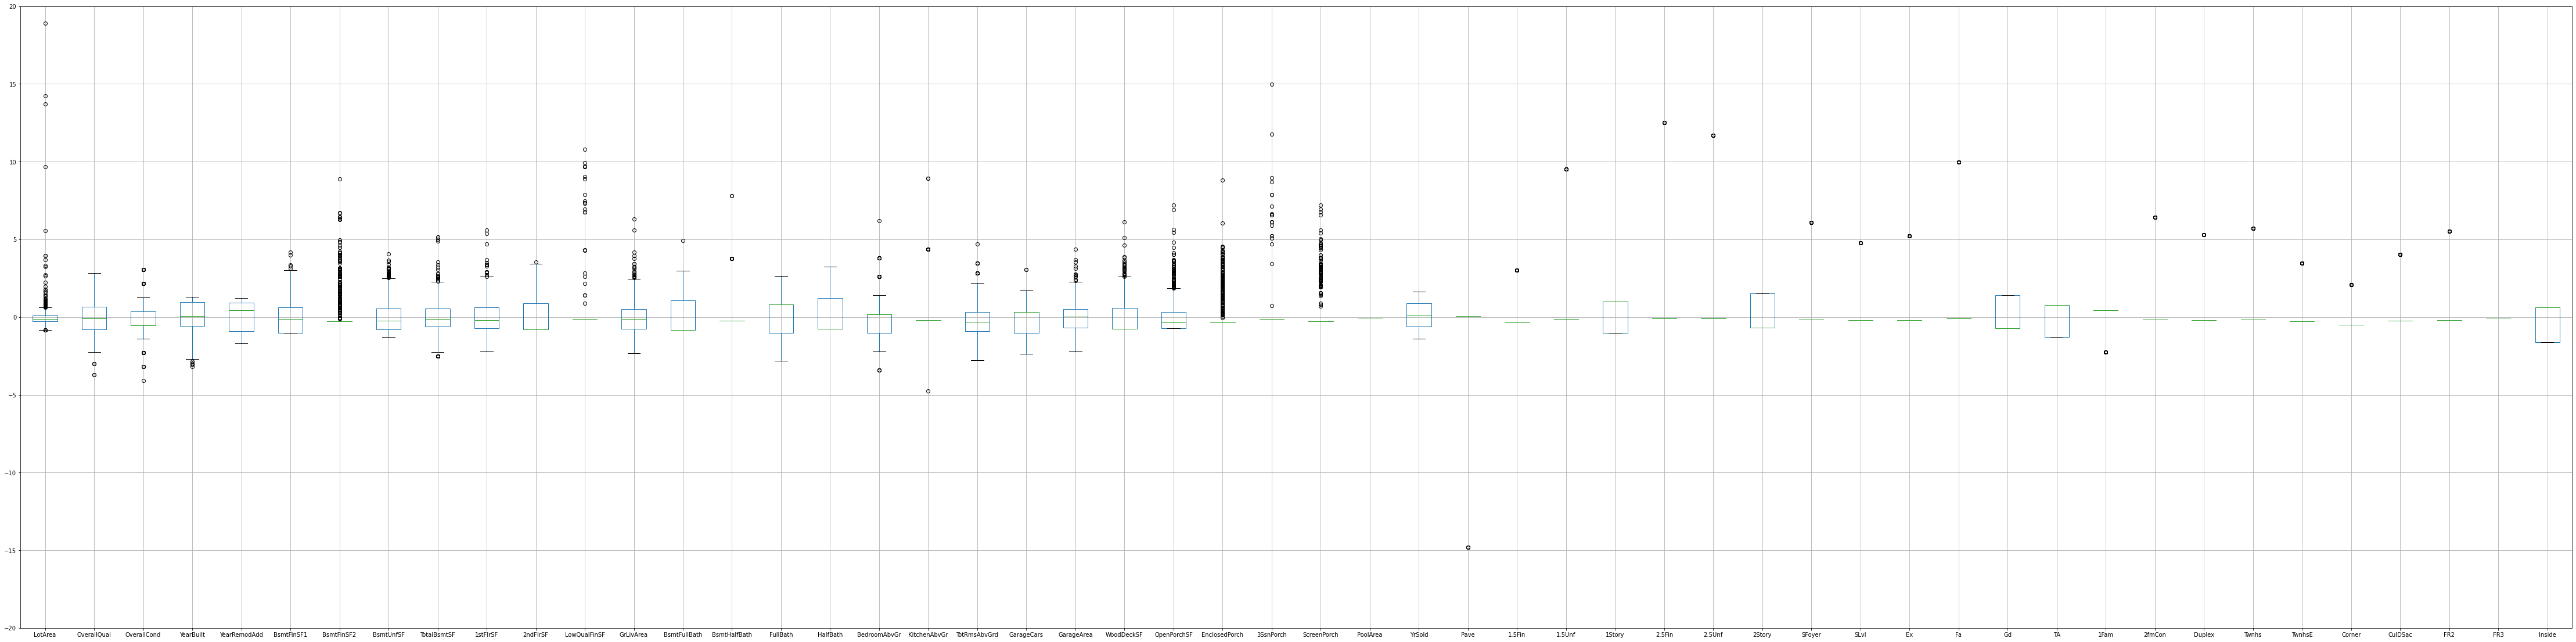

In [ ]:
# Scale features
from sklearn.preprocessing import StandardScaler

X_train_subset_scaled = StandardScaler().fit_transform(X_train_subset)
X_test_subset_scaled = StandardScaler().fit_transform(X_test_subset)

df = pd.DataFrame(X_train_subset_scaled, columns = X_train_subset.columns)
boxplot = df.boxplot(figsize=(200/2.54, 50/2.54))
plt.ylim(-20,20)


Running ols regression.
Mean squared error: 277372086155776847056964876763136.000
Coefficient of determination: -40440883130258815975424.000

Running ridge regression.
Mean squared error: 2272516620.439
Coefficient of determination: 0.669

Running huber regression.
Mean squared error: 2325049032.303
Coefficient of determination: 0.661

Running ransac regression.
Mean squared error: 48239548295662467612349709680640.000
Coefficient of determination: -7033331875312541106176.000

Running theil_sen regression.
Mean squared error: 3790120823.802
Coefficient of determination: 0.447


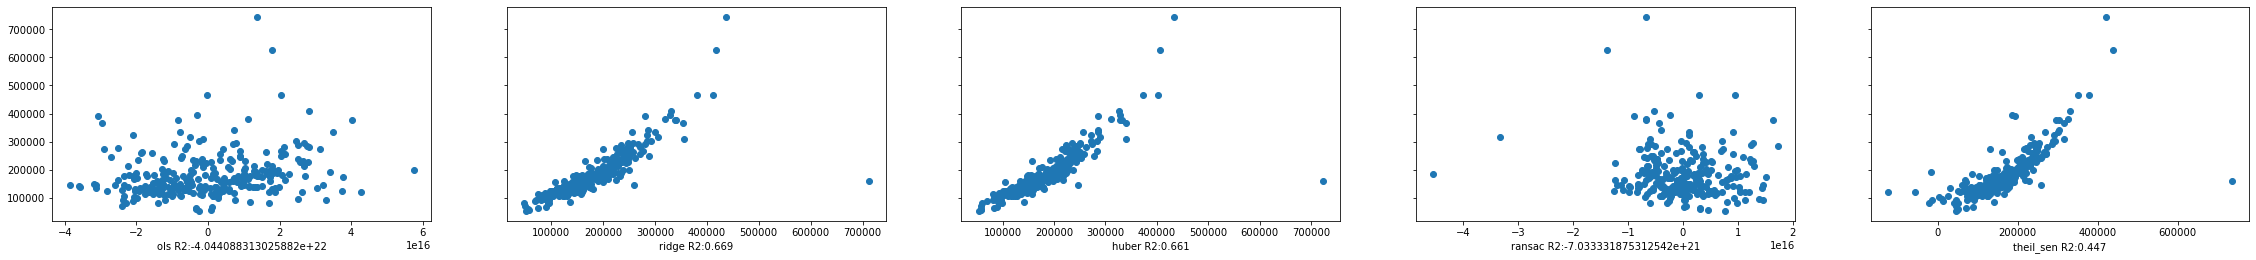

<Figure size 432x288 with 0 Axes>

In [ ]:
result = run_lin_regression(X_train_subset_scaled, y_train, X_test_subset_scaled, y_test, wrapped=False)
plot_predictions(result, y_test, data_in='dropped_scaled_Xonly')


Running ols regression.
Mean squared error: 2359823735.809
Coefficient of determination: 0.656

Running ridge regression.
Mean squared error: 2352863457.807
Coefficient of determination: 0.657

Running huber regression.
Mean squared error: 2370772907.554
Coefficient of determination: 0.654

Running ransac regression.
Mean squared error: 2845587443.066
Coefficient of determination: 0.585

Running theil_sen regression.
Mean squared error: 2637753497.978
Coefficient of determination: 0.615


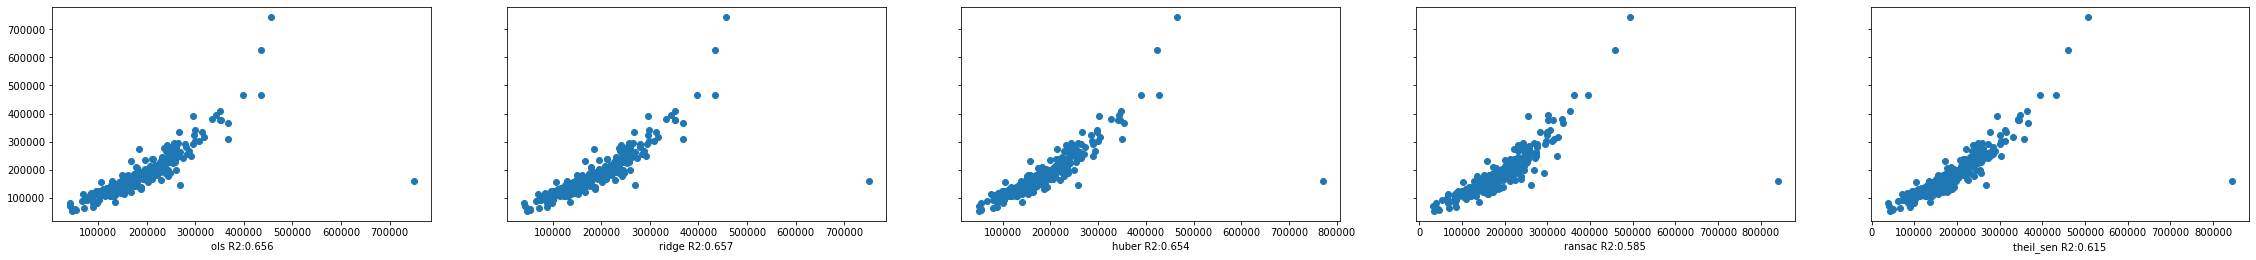

<Figure size 432x288 with 0 Axes>

In [ ]:
result = run_lin_regression(X_train_subset, y_train, X_test_subset, y_test, wrapped=True)
plot_predictions(result, y_test, data_in='dropped_scaled_wrapped')